Mona Mokart

## Face recognition



Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

# Goal
The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Let's load the data.

In [1]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./"   

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


Load the libraries

In [2]:
import math
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF


from scipy import linalg as LA
from scipy.stats import ortho_group

from scipy.io import loadmat

Here you can copy the functions `pcaLecture`, `KpcaGaussianLecture` and `FastICALecture` implemented in the previous jupyter-notebook.

In [3]:
# For IMP
def pcaLecture(X,nb_mode=2):
    ''' 
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
              column consists of features.
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of X onto the new basis given by the eigenvactors U
            of the covariance matrix of X. Columns are the principal components.
               
            U: columns are Eigenvectors (sorted from the greatest to the lowest eigenvalue)
    
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)
               
            var_explained: percentage of the original variability explained
            by each principal component.
    '''
    
    N=X.shape[0]
    Xc=X - np.mean(X,axis=0)  #centering

    D2, Uh = LA.svd(Xc)[1:3] # computation of eigenvectors and eigenvalues using SVD
    U=Uh.T
    Y=Xc@U[:,0:nb_mode] # computation of the scores
    D=D2**2/(N-1) # computation of the eigenvalues
    tot=np.sum(D)
    var_explained = np.array(D[:nb_mode]/tot) # computation of explained variance
    return Y,U,D,var_explained

In [4]:
# For IMP


 # kernel matrix using a rbf kernel
def kernel_matrix(X,gamma):
    N=X.shape[0]
    InnerX = np.dot(X,X.T)
    temp1=np.sum(X**2,axis=1).reshape((N,1))
    temp2=np.sum(X**2,axis=1).reshape((1,N))
    Norm1 = np.repeat(temp1,N,axis=1)
    Norm2 = np.repeat(temp2,N,axis=0) 
    Norm = Norm1+Norm2-2*InnerX;
    Norm[Norm<1e-10]=0;    
    K=np.exp(-Norm/(2*gamma**2))
    return K

def KpcaGaussianLecture(X,gamma,nb_mode=2):
    '''  
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
            column is a feature.
 
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of \phi(X) onto the new basis given by the eigenvactors 
            of the covariance matrix of \phi(X). Columns are the principal components.

            An: columns are Eigenvectors normalised (sorted from the greatest
            to the lowest eigenvalue)
     
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)

            var_explained: percentage of the original variability explained
            by each principal component.

    '''

       
    N=X.shape[0]

    K=kernel_matrix(X,gamma)
    
    # center kernel matrix
    oneN=np.ones((N,N))/N;
    Kc= K -oneN@K -K@oneN +oneN@K@oneN

    # eigenvalue analysis
    D,A=LA.eigh(Kc)     
    idx = D.argsort()[::-1]  # reverse order to make 'descend' 
    D = np.real(D[idx])
    D[D<0]=1e-18 # make negative eigenvalues positive (and almost 0)
    A = np.real(A[:,idx])

    # variance explained
    tot=np.sum(D)
    var_explained = D/tot # computation of explained variance

    # Normalisation eigenvectors
    # Norm of every eigenvector is 1, we want it to be 1/sqrt(N*eig)
    
    An=np.copy(A)
    for i in range(N):      
        An[:,i]=np.dot(A[:,i],(1/np.sqrt((N-1)*D[i])) )

        
    Y=Kc@(An[:,0:nb_mode])
    
    return Y,An,D,var_explained



In [5]:
# For IMP
def FastICALecture(X,N_Iter=3000,tol=1e-5,plot_evolution=0):
    '''
    Inputs: 
                   X: is a [d x N] matrix. Every column is an observation 
                   and every row is a feature.       
    
                   (Optional) N_Iter: maximum number of iterations
    
                   (Optional) delta: convergence criteria threshold
    
                   (Optional) plot_evolution: plot evolution of error
                   
     Outputs:      
                   S: [d x N] matrix.  Each column is an independent component 
                   of the centred and whitened input data X              
                   
                   W: [d x d] matrix. It is the demixing matrix. S = W*Xcw 
    
    '''
    
    # We choose G=-exp(-1/2t^2)
    # First derivative of G   
    def g(t): #XX
        res = t*np.exp(-0.5*t**2)
        return res
    
    # Second derivative of G  
    def gp(t): #XX
        res = (1-t**2)*np.exp(-0.5*t**2)
        return res
    
    # Size of X
    d,N=X.shape 
        
    # Compute sample mean
    mu = np.mean(X,axis=1)
    mu = mu[:,np.newaxis]#XX
    
    # Center data
    Xc=X-mu #XX
        
    # Whiten data
    cov = np.cov(X)
    omega = LA.cholesky(LA.inv(cov))
    Xcw=omega@Xc #XX
    
    
    
     # check if are whitened
    #if np.sum(np.eye(d) - np.abs(np.cov(Xcw)))>1e-10:
        #raise NameError('Your whitening transformation does not work...')
    
    # Initialize W
    W = ortho_group.rvs(d) # random orthogonal matrix 
    
    # delta evolution
    k = 0
    delta = np.inf
    evolutionDelta=[]
    
    while delta > tol and k < N_Iter:
    
        k = k + 1
        W_old = np.copy(W)
        

        Wp = g(W@Xcw)@(Xcw.T)-np.diag(gp(W@Xcw)@np.ones(N))@W
        

        W_inv_sqrt = LA.cholesky(LA.inv(Wp@Wp.T))
        W = W_inv_sqrt@Wp
        
        if np.sum(np.eye(d)-np.abs(np.dot(W,W.T)))>1e-10:
            raise NameError('W should be an orthogonal matrix. Check the computations')
                 
        delta = 1-np.min(np.abs(np.diag(np.dot(W.T,W_old))))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration ICA number ', k, ' out of ', N_Iter , ', delta = ', delta)
     
        
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')


    # Independent components
    S = W@Xcw
            
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - ICA')
        plt.show()
       
    return S,W

This is a useful function to plot the basis images. Be careful, each row of data is a basis image.

In [6]:
def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())
    #plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)
  

Let's load the data and compute some parameters.

In [7]:
x = loadmat(Working_directory + './YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')

There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


Let's plot first 10 images of different subjects and then 10 images of the same subject but with different positions and illumination conditions

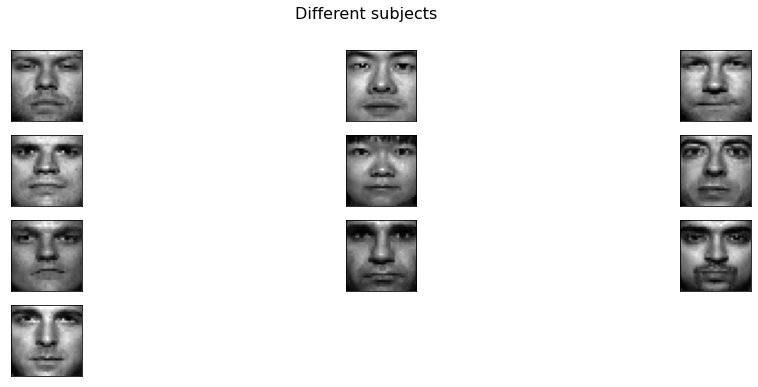

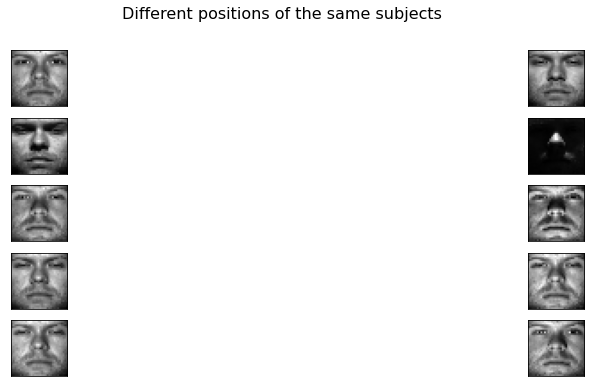

In [8]:
# Plot data      
indexDifferent=np.arange(1,Is*40,Is)     
plotFaces(data,r,c,ncol=3,indeces=indexDifferent[0:10],title='Different subjects')       
indexSame=np.arange(0,10,1)      
plotFaces(data,r,c,ncol=2,indeces=indexSame,title='Different positions of the same subjects')       


We can now use PCA to investigate the main variations within the data.

**Question:**
1. How many modes do you need to explain at least 80% of the variability in the data ? Look at the three main modes and explain which are the main variations in the data.

In [9]:
nb_mode=1
YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(data,nb_mode)
tot_var = np.sum(var_explainedPcaLec)
while tot_var<0.80:
    print("Total variation for",nb_mode,"modes :",tot_var)
    nb_mode +=1
    YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(data,nb_mode)
    tot_var = np.sum(var_explainedPcaLec)

print("We need", nb_mode, "modes to explain at least 80% of the data. Here the total variation is :", tot_var)

Total variation for 1 modes : 0.35945524740885526
Total variation for 2 modes : 0.7115662119224665
Total variation for 3 modes : 0.7602288770543586
Total variation for 4 modes : 0.7884903196937677
We need 5 modes to explain at least 80% of the data. Here the total variation is : 0.8038194050644804


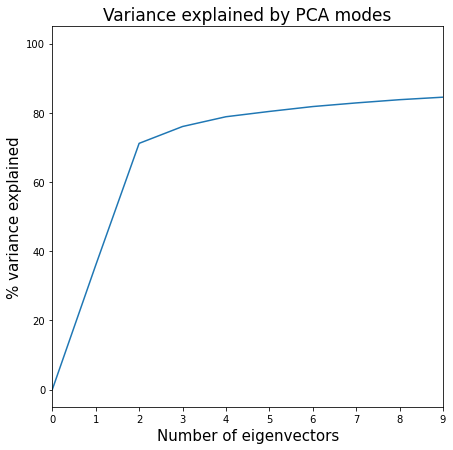

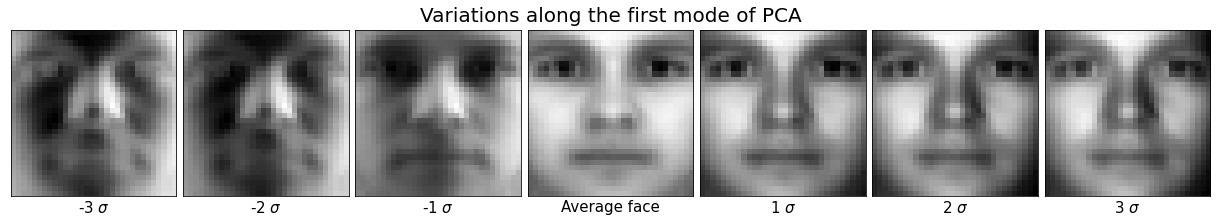

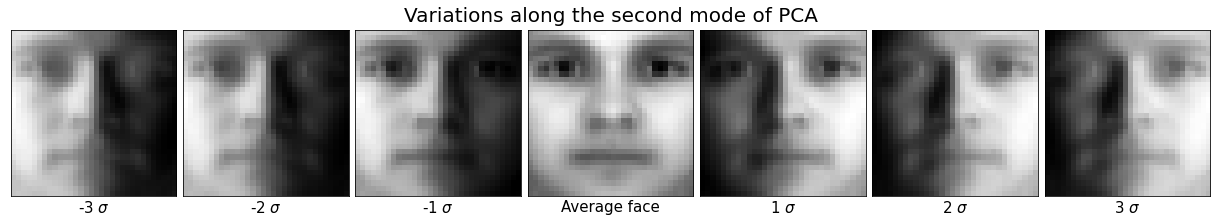

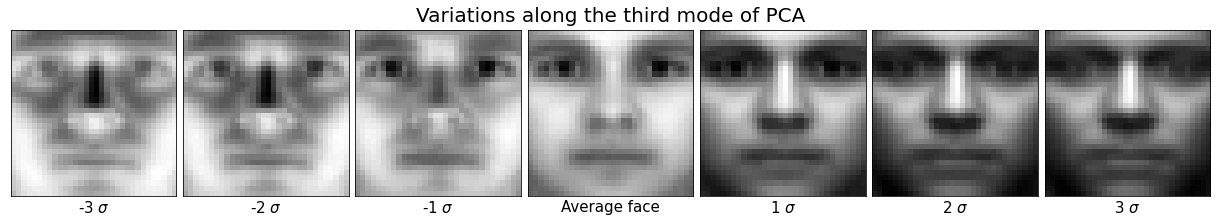

In [10]:
# Linear interpolation along the first two modes
Xm=data.mean(axis=0) # average face

pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
YpcaTrain=pca.fit_transform(data)
UpcaTrain=pca.components_.T # we want PC on columns
var_explained_pca=pca.explained_variance_ratio_
DpcaTrain = (pca.singular_values_)**2/(data.shape[0]-1) # computation of the eigenvalues
indices=np.linspace(-3, 3, num=7, dtype=np.int16) # Interpolation indices

# Variance explained by each eigenvector
fig=plt.figure(figsize=(7, 7))
ax=plt.subplot(111)
ax.set_xlim(0, 9)
dim=np.arange(0,10,1)
plt.plot(np.concatenate(([0], np.cumsum(var_explained_pca)*100)))
plt.xticks(dim)
plt.xlabel('Number of eigenvectors',fontsize=15)
plt.ylabel('% variance explained',fontsize=15)
plt.title('Variance explained by PCA modes',fontsize=17)

## First mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the first mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index * np.sqrt(DpcaTrain[0]) * UpcaTrain[:,0]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)


## Second mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the second mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index * np.sqrt(DpcaTrain[1]) * UpcaTrain[:,1]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

## Third mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the third mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index * np.sqrt(DpcaTrain[2]) * UpcaTrain[:,2]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

La première variance correspond à l'histogramme et la caractéristique "négative" de l'image

La deuxième variance correpond à l'éclairage horizontal

La troisème variance correspond à l'éclairage vertical

We can now move to evaluate the  performance of the dimensionality reduction techniques presented this morning for face recognition. We first divide the data-set into two parts, training (80%) and test (20%) in a stratified way (subjects are divided in a balanced way between the two parts).

We will see in the next lecture why we need to divide into training and test sets. For now, just know that we will use the first set to train our algorithm and the second set to test the performance of our algorithm on new, unseen data.

For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm
to evaluate the performance of the dimensionality reduction technique. For each test sample, the nearest neighbor algorithm simply looks for the closest training sample and then assigns the same label (i.e. index of subject).



In [11]:
Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest-np.mean(Xtest,axis=0) # centering, to have both training and test data centered
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering

As first idea, we could simply use the pixel intensities as features. This is basically like using the original data, without dimensionality reducton techniques.

In [12]:
## Use the pixel intensities to find the correct subject for the test images
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Xctrain,Id_Train.ravel())
print('By using the pixel intensities, we use ', Xctrain.shape[1], ' features')
print('Percentage of correct answer using the pixel intensities is ', NN.score(Xctest,Id_Test))


By using the pixel intensities, we use  1024  features
Percentage of correct answer using the pixel intensities is  0.7412008281573499


# PCA

You will first use PCA. Compute the scores $Y_{train}$, eigenvectors $U_{train}$ and eigenvalues $D_{train}$ of the training set. The eigenvectors $U_{train}$ represent the basis images and they are usually called *'Eigenfaces'*. Then, project both training and test data onto the eigenvectors that explain 99$\%$ of the variability of the training set $L_{train}^{99}$. You will obtain two vectors of scores, $Y_{train}^{99}=X_{train} L_{train}^{99}$ and $Y_{test}^{99}=X_{test} L_{test}^{99}$, which you will use for evaluating the performance of the algorithm. Use the function `KNeighborsClassifier` to test the performance.

**Practical Questions:** 
1. Use either the scikit-learn implementation or yours (better!) to test the performance, as previously explained. Furthermore, please comment the eigenfaces. Do they seem "real" ?

**Theoretical Questions:** 

1. In your opinion, why do we need to center the data before computing a PCA ? If you want, you can use the previous toy examples to answer this question.
2. Let $X$ be the original data, a matrix $\left[ N,d \right]$, and $Y$ the scores of a PCA keeping all eigenvectors, which means that $Y$ is also a matrix $\left[ N,d \right]$. Are $X$ and $Y$ equal ? If not, why ? What would you use (generally speaking) in a machine learning problem ? Why ?
3. Let $x_p$ and $x_q$ be two row-vectors representing two images, $U$ an *orthogonal* matrix whose columns are the eigenvectors of $X$ and $y_p=x_pU$, $y_q=x_qU$, check that $x_px_q^T=y_py_q^T$. This shows that $Y=XU$ is a linear transformation that preserves inner products.
4. Let $C$ be the covariance matrix of $X$ and $C=UDU^T$ its eigen decomposition. Show that the covariance matrix of $Y=XU$ is $D$.

Number of modes to reach 99% of total variability : 232
Percentage of correct answer using PCA is  0.7101449275362319


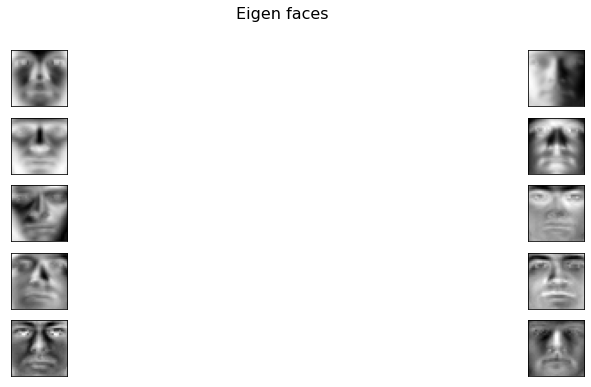

In [13]:
## PCA 
Y_pca_train, U_pca_train, D, var_explained_pca=pcaLecture(Xctrain,nb_mode = Xctrain.shape[1])
Y_pca_test, U_pca_test, D2, var_explained_pca2=pcaLecture(Xctest,nb_mode = Xctest.shape[1])

cum_var = np.cumsum(var_explained_pca)
mode_99 = np.argwhere(cum_var>0.99)[0][0]
Y_pca_train_99 = Y_pca_train[:,:mode_99]
print("Number of modes to reach 99% of total variability :",mode_99)

U_pca_train_99 = U_pca_train[:,:mode_99]
Y_pca_test_99 = Xctest@U_pca_train_99

NN.fit(Y_pca_train_99,Id_Train.ravel())
print('Percentage of correct answer using PCA is ', NN.score(Y_pca_test_99,Id_Test))  
plotFaces(U_pca_train.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='Eigen faces')

**Theoretical Questions - Answers**
1. Quand on utilise PCA on se sert de la décomposition en valeur singulière de X (les données) Cependant ça n'a de sens que lorsqu'elle est centrée car cette décomposition est équivalente à une décomposition en valeur propore de la matrice de covariance, ce qui n'est pas le cas si X n'est pas centrée. ($Xc^TXc = cov(X)*N$)
2. X et Y ne sont pas egaux car Y est ordonné et projeté selon les PC. Cependant il me semble que d'un point de vue computationel si on garde toutes les PCs on obtiendra le même résultat. Cela peut être utile si on choisit après le calcul le nombre de PC qu'on garde
3. $y_py_q^T = x_pUU^Tx_q^T = x_pI_dx_q^T = x_px_q^T$
4. $C = X_c^TX_c/N = UFU^T \mbox{ Donc : cov(Y)} = Y_c^TY_c/N = U^TX_c^TX_cU/N =U^TCU = U^TUDU^TU = D$


# KPCA

In this section, we are going to do exactly the same procedure as before but using Kernel-PCA with a Gaussian kernel. Remember that we need to compute and center the test kernel matrix $[\mathbf{\tilde{K}}]_{ij}=<\phi(x_i)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)>$ and that, once computed the basis vectors in the training set $\{  \mathbf{\alpha}_i \}$, we can compute the score for a test sample $t$ using the following equation:

$y_i(t) = \sum_{j=1}^N a_{ij} <\phi(t)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)> = \sum_{j=1}^N a_{ij} \tilde{k}(t,x_j)$

Answer the following questions:

**Questions:** 

1.  Use either the scikit-learn implementation or yours (better!) to test the performance
2. Look for the best gamma value
3. Why the basis vectors $\{  \mathbf{\alpha}_i \}$ are not plotted as in PCA ?
4. Is it worth it, in your opinion, to compute PCA and/or KPCA ? Why not using the original pixel intensities ? Please consider the following aspects in your answer: performance, computational time, number of features, and interpretability of the results.
5. (Optional) Create a new function `Kpca_poly_lecture` where you change the kernel to $k(x,y)=<x,y>^d$. Evaluate the performance of this new kernel.


In [14]:
## KPCA 
YKpca_train, AnKpca_train, DKpca, var_explainedKpca = KpcaGaussianLecture(Xctrain,14,nb_mode = Xctrain.shape[0])
cum_var = np.cumsum(var_explainedKpca)
mode_99_train = np.argwhere(cum_var>0.99)[0][0]
Y_train_99_Kpca = YKpca_train[:,:mode_99_train]


YKpca_test, AnKpca_test, DKpca, var_explainedKpca2 = KpcaGaussianLecture(Xctest,14,nb_mode = Xctest.shape[0])
Y_test_99_Kpca = YKpca_test[:,:mode_99_train]


NN.fit(Y_train_99_Kpca,Id_Train.ravel())
print('Percentage of correct answer using KPCA is ', NN.score(Y_test_99_Kpca,Id_Test))

Percentage of correct answer using KPCA is  0.035196687370600416


2. Le meilleur gamma est 14 sinon on a un problème de dimension
3. Avec KPCA on connait seulement les projections de $\phi(t)$ sur les PC dans $\mathcal{R}^\mathcal{f}$ mais pas de X dans $\mathcal{R}^\mathcal{d}$
4. C'est utile d'utiliser PCA car cela réduit la dimension de X donc le temps de calcul par la suite. De plus les résulats fournits par PCA permettent de garder un pourcentage de résussite proche de celui avec les intesités des pixels. Cependant avec KPCA on  un résultat très mauvais cela ne vaut pas le coup. Utiliser les intensités peut être très long avec des images de grandes dimensions
5. 


# ICA

In the next section you will evaluate ICA. Every image $x_i$ can be seen as a linear combination of basis images. ICA can be used in two different ways for face recognition. We can look for a set of statistically independent basis images $s_j$ (first architecture) or for a set of statistically independent coefficients $a_{j}$ (second architecture).

In the first architecture, we compute $X'=A'S'$, where every row of $X'$ is an image and the columns are pixels. Images are considered as random variables and we look for a set of statistically independent basis images contained in the rows of $S'$.

In the second architecture, we transpose the previous setting computing $X''=A''S''$, where every column of $X''$ is an image and rows are pixels. In this case, we consider the pixels as random variables and we look for a set of statistically independent coefficients contained in the rows of $S$ and a set of basis images in the columns of $A$.

Instead than using the original training data $X$ as input matrix, we are going to use the eigenvectors (first architecture) or the scores (second architecture) computed with PCA, namely $Y=XL$ (same notation as in the slides of the lecture). In this way, we reduce the computational time since the number of eigenvectors that account for 99\% of the variance of the training images (columns of $L$) is definitely lower than the number of pixels (columns of $X$). If you want, you can of course use the original data but it will take much more time to converge.

For the first architecture we will use $L^T$ as input matrix. In fact, we can notice that the PCA approximation of the matrix $X_{train}$, containing an image in every row, can be written as $\tilde{X} = YL^T$. If we use $L^T$ as input in the ICA algorithm we obtain $L^T=AS$, thus it follows that $\tilde{X}=YW^TS$ (since $A=W^{-1}=W^T$). The basis images are contained in the rows of $S$ and the coefficients used for evaluating the performance are instead contained in the rows of $Y_{train}W^T$ for the training set and in $Y_{test}W^T$ for the test set.

For the second architecture, we will instead use $Y^T$ as input matrix thus obtaining $Y^T=AS$. Remember that in the second architecture we want to apply the ICA algorithm to the transpose of $X_{train}$, namely $X^T=AS$. We can notice that, given the PCA transformation $Y=XL$, one can write $X \approx YL^T$ which entails $X^T \approx LY^T=LAS=LW^TS$. The columns of $LW^T$ contain the basis images whereas the columns of $S$ contain the statistically independent coefficients used to test the performance of the algorithm. The coefficients for the test set are in the columns of $S_{test}=W_{train}Y_{test}^T$.

NB: Here we used $X=X_c$ which means centered face images

**Questions:**
 
1. Use either the scikit-learn implementation or yours (better!) to test the performance of the two architectures
2. Look at the results of the two architecures. Which one is better ?
3. Looking at the basis images, in which case do they seem more 'real' ?




Percentage of correct answer using the first architecture of ICA is  0.7908902691511387


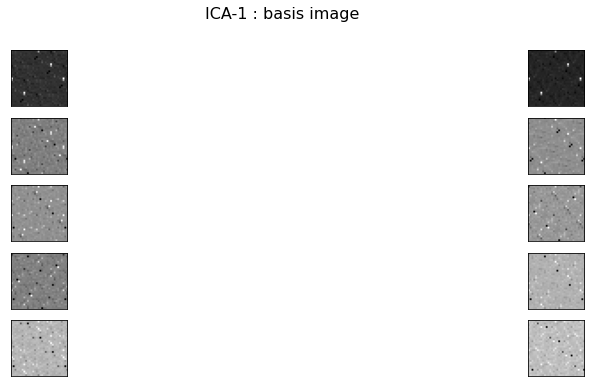

In [15]:
## ICA - First architecture 
ICA= FastICA(whiten=True, fun='exp', max_iter=30000, tol=0.00001, random_state=1)
S_ica=ICA.fit_transform(U_pca_train_99)
A_ica=ICA.mixing_


ICA1_train= Y_pca_train_99@A_ica
ICA1_test= Y_pca_test_99@A_ica


NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(ICA1_train,Id_Train.ravel())
print('Percentage of correct answer using the first architecture of ICA is ', NN.score(ICA1_test,Id_Test))

plotFaces(S_ica,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA-1 : basis image') 

Percentage of correct answer using the first architecture of ICA is  0.16356107660455488


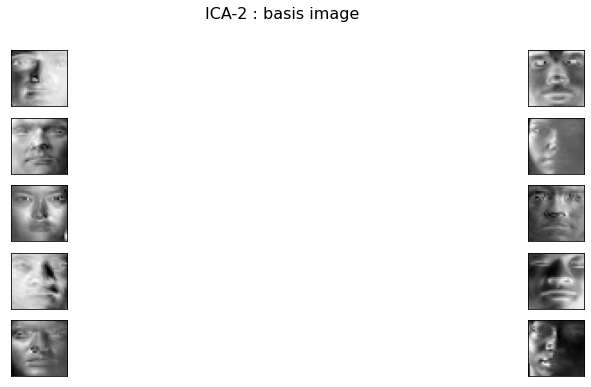

In [16]:
## ICA - Second architecture
ICA= FastICA(whiten=True, fun='exp', max_iter=30000, tol=0.00001, random_state=1)
S_ica=ICA.fit_transform(Y_pca_train_99)
A_ica=ICA.mixing_


ICA2_train= S_ica
ICA2_test= Y_pca_test_99@A_ica


NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(ICA2_train,Id_Train.ravel())
print('Percentage of correct answer using the first architecture of ICA is ', NN.score(ICA2_test,Id_Test))

plotFaces((U_pca_train_99@A_ica).T,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA-2 : basis image') 

1. J'ai utilisé sklearn car je ne suis pas sûre de ma fonction FastICALecture.
2. Les résultats sont nettements meilleurs avec la première architecture 
3. Les images-bases sont en revanche plus réelles dans la seconde architecture.

# NNMF

Here you will test Non-negative Matrix factorization. The basis images of the training are in the matrix $W_{train}$ and the scores (or coefficients) to test the performance in $H_{train}$. The test scores are computed as $H_{test}=W_{train}^{-1}X_{test}$.

**Question**

1. Use the scikit-learn implementation to test the performance.
2. Plot the basis images and compare them with respect to the basis images obtained using PCA and ICA. What can you say ?
3. What about the performances of NNMF, i.e. computational time and classification accuracy ? Is it better or worse than the other methods ? Why ?
4. (Optional) Implement your own implementation in `NNMFLecture` following the lecture slides. Complete the missing lines (`XXXXXXXXXX`) 

NNMF uses  30  features
Percentage of correct answer using NNMF is  0.7204968944099379


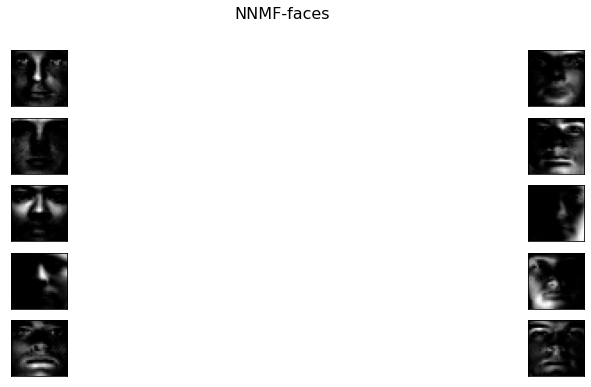

In [17]:
# NNMF (scikit-learn implementation)
Ncomponents= 30# choose a number of componenents (r in the slides)
model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
WtrainNNMF = model.fit_transform(Xtrain.T)
HtrainNNMF = model.components_

plotFaces(WtrainNNMF.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces') 

Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),Xtest.T)

print('NNMF uses ', Ncomponents, ' features')

# Score
NN.fit(HtrainNNMF.T,Id_Train.ravel())
print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))


1. ci-dessus
2. Les images-bases de NNMF ressemblent à des visages réels comme pour PCA et la seconde architecture de ICA. Cependant elles sont plus sombres 
3. Avec r = 50 on a 80% de bonnes réponses avec le testset ce qui est meillleur qu'en utilisant les 1024 pixels, en plus du fait qu'on réduit beaucoup le nombre de feature. Avec r=30 on retrouve à peu près le même pourcentage de précision qu'en utilisant les intensités de pixels. Ainsi cette méthode de donne de très bons résultats en réduisant beaucoup la dimension des données (plus qu'avec PCA et KPCA) donc en résuisant les calculs.

In [18]:
# OPTIONAL
def NNMFLecture(X,r=None,N_Iter=1000,tolerance=1e-3,plot_evolution=1):
    '''
    Inputs: 
    %           X: is a [dxN] matrix. Every column (x) is an observation and every
    %           row consists of features.
    %
    %           r: size of the matrices W and H
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           W: is a [d x r] matrix containing the basis images in its
    %           columns
    %           
    %           H: is a [r x N] matrix containing the loadings (h) in its columns
    %           of the linear combination: x=Wh 
    %
  '''
    if r is None:
        r=X.shape[0]
        
    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')      

    # Size
    d,N=X.shape
   
    # Initialization
    W=np.random.rand(d,r)
    H=np.random.rand(r,N)     
    
    # parameters for convergence
    k = 0
    delta = np.inf
    eps=np.finfo(float).eps
    evolutionDelta=[]
 
    while delta > tolerance and k < N_Iter:
        
        # multiplicative method      
        for i in range(20):
            W = np.divide(XXXXXXXX + eps)           
            
        H = np.divide(XXXXXXXXXX + eps)

        # Convergence indices
        k = k + 1           
        diff=X-np.dot(W,H)     
        delta = LA.norm(diff,'fro') / LA.norm(X,'fro') # sqrt(trace(diff'*diff)) / sqrt(trace(X'*X))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration NNMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', LA.norm(diff))
     
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')
    
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - NNMF')
        plt.show()
    
    return W,H

In [19]:
# OPTIONAL
# NNMF (test your own implementation)
XXXXXXXXXXX

NameError: name 'XXXXXXXXXXX' is not defined

Here, we check that using the original data for ICA is definitely too long. In scikit-learn we directly select the number of components $p$. However, results are less satisfactory than using PCA as before or too long.

In [ ]:
# Shuffle data randomly and use only 300 components (p=300)
indeces=np.arange(data.shape[0]) # Integers from 0 to N-1
np.random.shuffle(indeces)
sample=data[indeces,:]

#first architecture (scikit-learn implementation)
ICA= FastICA(whiten=True, fun='exp', max_iter=30000, algorithm='parallel', tol=1e-4, random_state=1, n_components=300)
Yica=ICA.fit_transform(sample)
Sica=Yica.T
Aica=ICA.mixing_
Wica=ICA.components_

# Plot the Eigenfaces
plotFaces(Sica,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA basis images (first architecture)')  


In [ ]:
#second architecture (scikit-learn implementation)
ICA= FastICA(whiten=True, fun='exp', max_iter=30000, algorithm='parallel', tol=1e-4, random_state=1, n_components=300)
Yica=ICA.fit_transform(data.T)
Sica=Yica.T
Aica=ICA.mixing_
Wica=ICA.components_

# Plot the Eigenfaces
plotFaces(Aica.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA basis images (second architecture)')  